In [1]:

import os
from gc import disable
from sys import displayhook

import pandas as pd
import numpy as np
import numpy.lib.recfunctions as rfn
from scipy.stats import skew, kurtosis

from io import StringIO
import time

import matplotlib.pyplot as plt
from datetime import datetime, date

from tkinter import filedialog
import tkinter as tk
from tqdm import tqdm
import glob

import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import natsort

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR

import seaborn as sns

import http.client
import json

import os
import re
from tqdm import tqdm
from datetime import datetime

#from gps_parameters import GpsConverter1

In [3]:
def calibration(raw_df):

    def int_to_datetime(integer):
        try:
            str_dt = str(integer).zfill(6)  # 입력값이 짧으면 앞에 0을 추가
            result_dt = datetime.strptime(str_dt, '%H%M%S')  # 시간 형식으로 변환
            result_unix = result_dt.timestamp()  # 유닉스 타임스탬프로 변환
            return result_unix
        except ValueError as e:
            print(f"ValueError: {integer} is not a valid time format.")
            raise e

    def foam2(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape
        N = c1
        H = c1//2
        pC1 = np.mean(base[:,0:H],1)
        qC1 = np.mean(target[:,0:H],1)
        pC2 = np.mean(base[:,H:c1],1)
        qC2 = np.mean(target[:,H:c1],1)
        pC1 = pC1.reshape(-1,1)
        qC1 = qC1.reshape(-1,1)
        pC2 = pC2.reshape(-1,1)
        qC2 = qC2.reshape(-1,1)

        pp = np.zeros((r1,c1))
        pp[:,0:H] = base[:,0:H] - pC1
        pp[:,H:c1] = base[:,H:c1] - pC2
        qp = np.zeros((r2,c2))
        qp[:,0:H] = target[:,0:H] - qC1
        qp[:,H:c1] = target[:,H:c1] - qC2
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC1 - np.matmul(R, pC1)
        t2 = qC2 - np.matmul(R, pC2)
        pp = np.zeros((r1,c1))
        pp[:,:H] += np.matmul(R,base)[:,:H] + t1
        pp[:,H:] += np.matmul(R,base)[:,H:] + t2
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,t2,err

    def foam(base, target):
        r1,c1 = base.shape
        r2,c2 = target.shape

        pC = np.mean(base[:,:],1)
        qC = np.mean(target[:,:],1)
        pC = pC.reshape(-1,1)
        qC = qC.reshape(-1,1)

        pp = np.zeros((r1,c1))
        pp[:,:] = base[:,:] - pC
        qp = np.zeros((r2,c2))
        qp[:,:] = target[:,:] - qC
        B = qp.dot(pp.T)
        detB = np.linalg.det(B)
        froBsq = (np.linalg.norm(B,'fro'))**2
        try:
            invB = np.linalg.inv(B)
        except Exception as e:
            raise e
            return False, False, False
        invB = np.linalg.inv(B)
        adjB = detB *invB
        froadjBsq = np.linalg.norm(adjB,'fro')**2
        lam = 0.5*(np.sum(qp**2)+np.sum(pp**2))
        lamprev = 0.0
        while abs((lam-lamprev)/lam) >= 1e-12:
            lamprev = lam
            tmp = lam**2 - froBsq
            lam = lam - (tmp**2 - 8*lam*detB - 4*froadjBsq)/(4*tmp*lam - 8*detB)
        R = ((lam**2 + froBsq)*B + 2*lam*adjB.T - 2*np.matmul(B,np.matmul(B.T,B))) / (lam*(lam**2 - froBsq) - 2*detB)
        t1 = qC - np.matmul(R, pC)
        pp = np.zeros((r1,c1))
        pp[:,:] += np.matmul(R,base)[:,:] + t1
        err = np.mean(np.sqrt(np.sum((target-pp)**2,1)))
        return R,t1,err

    def movmean(lst, window):
        return np.convolve(lst, np.ones(window)/window, mode='same')

    def get_pseudo_acc(timestamp, gps_speed, gps_heading):
        #timestamp_seconds = timestamp.astype('int64') / 1e9
        if gps_heading[0] == None:
            gps_heading[0] = gps_heading.copy()[1]
        gps_speed_ms = gps_speed/3.6
        #gps_heading_tmp = np.deg2rad(gps_heading)
        gps_heading_rad = np.unwrap(gps_heading)
        pgyrZ = np.convolve(np.gradient(-gps_heading_rad)/np.gradient(timestamp), np.ones(10)/10, mode='same')
        paccX = np.gradient(gps_speed_ms)/np.gradient(timestamp)
        paccY = pgyrZ * gps_speed_ms
        return paccX, paccY, pgyrZ


    def static_imu_align(data, use_gyro = False, speed_thres = 5):
        #display(data)
        data = data.copy()
        # mask = np.where((data['numSV']<satellite_thres) | (data['Speed']<=speed_thres))
        mask = np.where((data['Speed']/3.6<=speed_thres))

        pseudo_acc_x, pseudo_acc_y, pseudo_gyr_z = get_pseudo_acc(data["TimeStamp"], data['Speed'], data['Heading'])
        pseudo_acc_z = np.ones(len(pseudo_gyr_z))*9.816
        pseudo_gyr_x = np.zeros(len(pseudo_gyr_z))
        pseudo_gyr_y = np.zeros(len(pseudo_gyr_z))

        pseudo_acc_x[mask] = 0
        pseudo_acc_y[mask] = 0
        pseudo_acc_z[mask] = 0
        pseudo_gyr_z[mask] = 0

        raw_acc_x = movmean(data['AccelX'],20)
        raw_acc_y = movmean(data['AccelY'],20)
        raw_acc_z = movmean(data['AccelZ'],20)
        raw_gyr_x = movmean(data['AngleRateX'],20)
        raw_gyr_y = movmean(data['AngleRateY'],20)
        raw_gyr_z = movmean(data['AngleRateZ'],20)

        raw_acc_x[mask] = 0
        raw_acc_y[mask] = 0
        raw_acc_z[mask] = 0
        raw_gyr_x[mask] = 0
        raw_gyr_y[mask] = 0
        raw_gyr_z[mask] = 0

        if use_gyro:

            # R*base + bias = target
            base = np.hstack((np.vstack((raw_acc_x, raw_acc_y, raw_acc_z)), np.rad2deg(np.vstack((raw_gyr_x, raw_gyr_y, raw_gyr_z)))))
            target = np.hstack((np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z)), np.rad2deg(np.vstack((pseudo_gyr_x, pseudo_gyr_y, pseudo_gyr_z)))))

            rotmat, bias_acc, bias_gyr, err = foam2(base, target)

        else:
            base = np.vstack((raw_acc_x, raw_acc_y, raw_acc_z))
            target = np.vstack((pseudo_acc_x, pseudo_acc_y, pseudo_acc_z))

            rotmat, bias_acc, err = foam(base, target)
            bias_gyr = np.mean(np.deg2rad(np.vstack((raw_gyr_x[mask], raw_gyr_y[mask], raw_gyr_z[mask]))), axis = 1)

        return (rotmat, bias_acc, np.deg2rad(bias_gyr), err)

    df = raw_df.copy()
    df = df.loc[(df["numSV"] > 5) & (df["Speed"] > 3)].copy()
    # Remove duplicate time for cali
    # df.drop_duplicates(subset=['datetime'], inplace=True)
    #df['unixtime'] = list(map(lambda x: int_to_datetime(x), df.index))

    # KEY MATCHING for Smartlink
    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())
    data = np.array([tuple(x) for x in np.vstack( \
                # (df_N088_filtered['iTOW']/1000.0, \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"]
                    )).T], \
                    # df_sk_filtered['lat'], \
                    # df_sk_filtered['lon'])).T], \
                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),
                        ])
                        # ('Latitude', None), \
                        # ('Longitude', None)])

    # RUN CALIBRATION
    try:
        rotmat, bias_acc, bias_gyr, err = static_imu_align(data, use_gyro=True)
        #display(rotmat)
        cal_acc = np.matmul(rotmat, np.vstack((raw_df['AccelX'], raw_df['AccelY'], raw_df['AccelZ']))) + bias_acc.reshape(3,1)
        cal_gyr = np.matmul(rotmat, np.vstack((raw_df['AngleRateX'], raw_df['AngleRateY'], raw_df['AngleRateZ']))) + bias_gyr.reshape(3,1)
    except Exception as e:
        print(e)
        raise e

    import time
    try:
        cal_name = "cal"
        raw_df['AccelX'] = cal_acc[0]
        raw_df['AccelY'] = cal_acc[1]
        raw_df['AccelZ'] = cal_acc[2]
        raw_df[f'AngleRateX'] = cal_gyr[0]
        raw_df[f'AngleRateY'] = cal_gyr[1]
        raw_df[f'AngleRateZ'] = cal_gyr[2]
    except Exception as e:
        print(e)
        raw_df = rfn.append_fields(raw_df,'AccelX', cal_acc[0])
        raw_df = rfn.append_fields(raw_df,'AccelY', cal_acc[1])
        raw_df = rfn.append_fields(raw_df,'AccelZ', cal_acc[2])
        raw_df = rfn.append_fields(raw_df,'GyroX', cal_gyr[0])
        raw_df = rfn.append_fields(raw_df,'GyroY', cal_gyr[1])
        raw_df = rfn.append_fields(raw_df,'GyroZ', cal_gyr[2])
        raise e
    return raw_df

In [4]:
import warnings
warnings.filterwarnings("ignore", message="'DataFrame.swapaxes' is deprecated")

def detection(data, s_dist=200, e_dist = 150, numSV_ths = 10):
    data = data.fillna(0)

    data_outage = data.loc[data["numSV"] == 0]

    def group_consecutive(data):
     return np.split(data, np.where(np.diff(data.index) != 1)[0] + 1)

    data_outage_split = group_consecutive(data_outage)

    def filter_outage_sections(data_outage_split, speed_col="Speed", threshold=0.7):
        """
        주어진 리스트에서 정지 인덱스가 전체의 70% 이상인 섹션을 제거.
        """
        filtered_sections = []
        for outage_section in data_outage_split:
            zero_vel_index = outage_section.loc[(outage_section[speed_col] < 1)].index
            if len(zero_vel_index) <= threshold * len(outage_section):
                filtered_sections.append(outage_section)
        return filtered_sections

    data_outage_split = filter_outage_sections(data_outage_split)
    # 여기에서 시작 끝 점 기준으로 특정 인덱스 범위만큼 더 간 값들까지 붙여서 반환

    for idx, outage_section in enumerate(data_outage_split):
        outage_section = outage_section.fillna(0)

        s_i, o_i = outage_section.index[0], outage_section.index[-1]
        print(s_i, o_i)

        p_si, p_oi = data.loc[s_i - 10], data.loc[o_i + 10]

        try:
            s_o = s_i - int(s_dist/p_si["Speed"])
        except Exception as e:
            print("zero speed, detect as default distance")
            s_o = s_i - 7

        try:
            o_o = o_i + int(e_dist/p_oi["Speed_175"])
        except Exception as e:
            print("zero speed, detect as default distance")
            o_o = o_i + 5

        not_sat_s = True
        not_parking = True


        while not_sat_s:
            if o_o - s_o > 80:
                print("regard as parking")
                not_parking = False
                break

            if (data.loc[s_o]["numSV"] > numSV_ths) and (data.loc[o_o]["numSV"] > numSV_ths):
                not_sat_s = False

            if (data.loc[s_o]["numSV"] <= numSV_ths) or pd.isna(data.loc[s_o, "numSV"]):
                s_o = s_o - 1
            if (data.loc[o_o]["numSV"] <= numSV_ths):
                o_o = o_o + 1



        outage_section_fin = pd.concat([data.loc[s_o-1:s_i-1], outage_section, data.loc[o_i + 1: o_o + 1]], axis = 0)

        outage_section_fin["TimeStamp"] = pd.to_datetime(outage_section_fin["datetime"], format="%Y-%m-%d %H:%M:%S")
        outage_section_fin["UnixTime"] = outage_section_fin["TimeStamp"].apply(lambda x: x.timestamp())
        # time_delta = outage_section_fin["UnixTime"].diff()
        # time_delta = np.insert(time_delta, 0, time_delta[0])

        outage_section_fin = outage_section_fin.loc[outage_section_fin["UnixTime"].diff()> 0]

        if not_parking:
            data_outage_split[idx] = outage_section_fin #.drop(columns=["UnixTime"])
        else:
            data_outage_split[idx] = "parking"

    return data_outage_split

pio.renderers.default = "browser"

acc_file = pd.read_csv(fr"C:\Users\양준원\PycharmProjects\DPS_GPS_Outage\20240909.csv").drop(columns=["Unnamed: 0"])
acc_file = calibration(acc_file)

result = detection(acc_file.loc[14800:15000])

result = [acc_file.loc[:7500].copy()]

for outage_file in result:
    #display(outage_file.describe(include="all"))
    fig = px.scatter_mapbox(outage_file, lat = f'lat', lon= f'lon', zoom=15, mapbox_style='open-street-map', color_continuous_scale='turbo').update_traces(marker={'size':5})
    fig.update_layout(
        width = 1200,
        height = 900,
        margin = dict(l=0, r=0, t=0, b=0),
    )
    fig.show()

14810 14830
zero speed, detect as default distance


Height diff as 2.6559999999999917   estimated as 2.4753938252518837
Speed diff as -3.2059999999999995   estimated as -3.7331396970701203
Heading diff as 4.511624280126558   estimated as -1.0730179325201599
Slope diff as -0.07774181235912922   estimated as 0.008720814141990533
X diff as -22.67601857279256   estimated as 34.85080935671445
Y diff as 217.73854193560572   estimated as 265.1333530420482
start heading : 0.552809478624302 X : 0.0 Y : 0.0 height : 69.528 slope : 0.041338966113281146 speed : 16.029
end heading : 5.06443375875086 X : -22.67601857279256 Y : 217.73854193560572 height : 72.184 slope : -0.03640284624584807 speed : 12.823
estimated end heading : -0.5202084538958579 X : 34.85080935671445 Y : 265.1333530420482 height : 72.00339382525189 slope : 0.008720814141990533 speed : 12.29586030292988
--------------------
x diff as [ 0.12974807  0.57634333  1.23467897  2.08911968  2.93734992  3.81598973
  5.16982448  7.17516648  9.77958775 12.8709184  16.41657495 20.31322538
 24.7

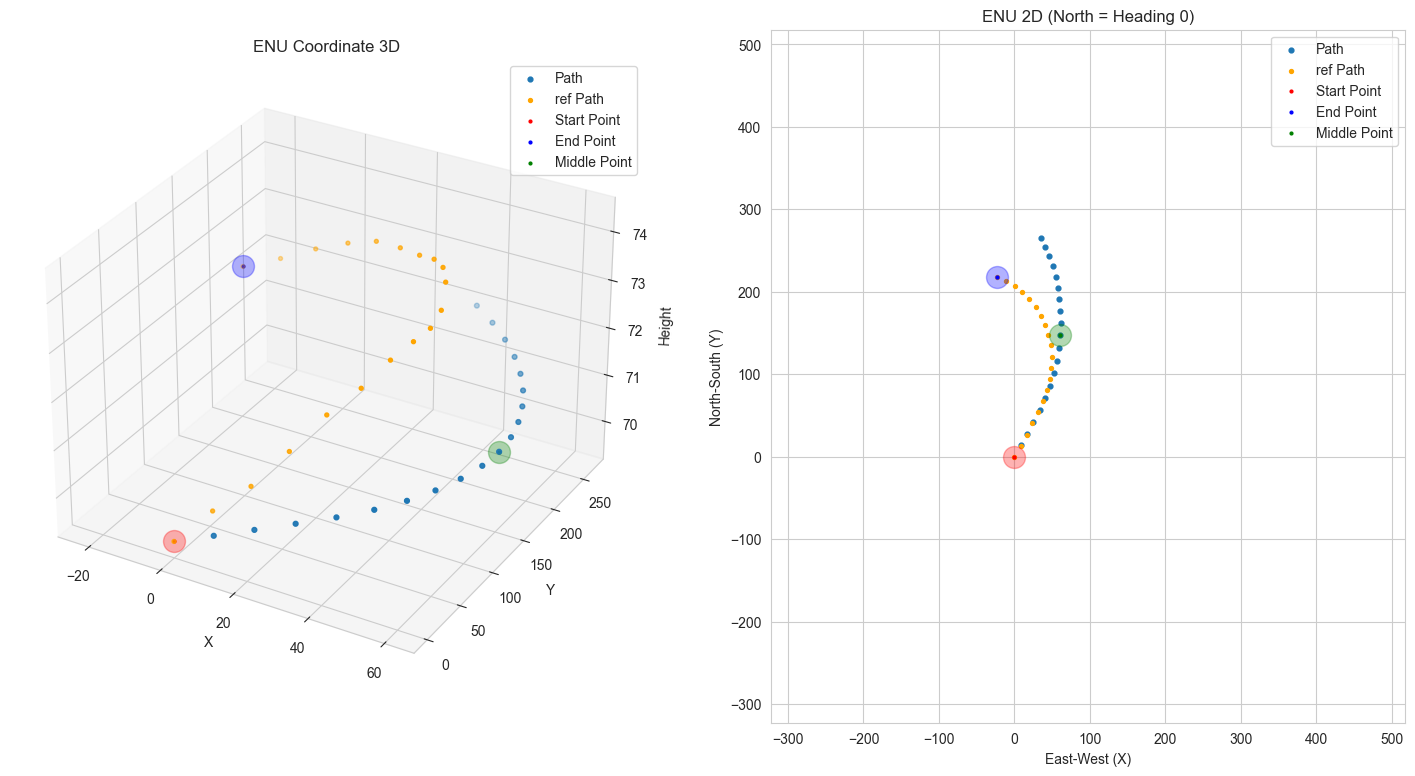

Height diff as 2.6559999999999917   estimated as 2.6559999999999917
Speed diff as -3.2059999999999995   estimated as -1.654023940558604
Heading diff as 4.511624280126558   estimated as 117.6089598093591
Slope diff as -0.07774181235912922   estimated as 0.010629675128411557
X diff as -22.67601857279256   estimated as -22.67601857279257
Y diff as 217.73854193560572   estimated as 217.73854193560572
start heading : 0.552809478624302 X : 0.0 Y : 0.0 height : 69.528 slope : 0.041338966113281146 speed : 16.029
end heading : 5.06443375875086 X : -22.67601857279256 Y : 217.73854193560572 height : 72.184 slope : -0.03640284624584807 speed : 12.823
estimated end heading : 118.1617692879834 X : -22.67601857279257 Y : 217.73854193560572 height : 72.184 slope : 0.010629675128411557 speed : 14.374976059441396
--------------------
x diff as [160.10020068 146.88098844 132.72784324 117.85749269 103.11053998
  89.05518385  76.26079602  64.4382024   53.33715837  43.10174614
  33.9094416   26.11791707  19

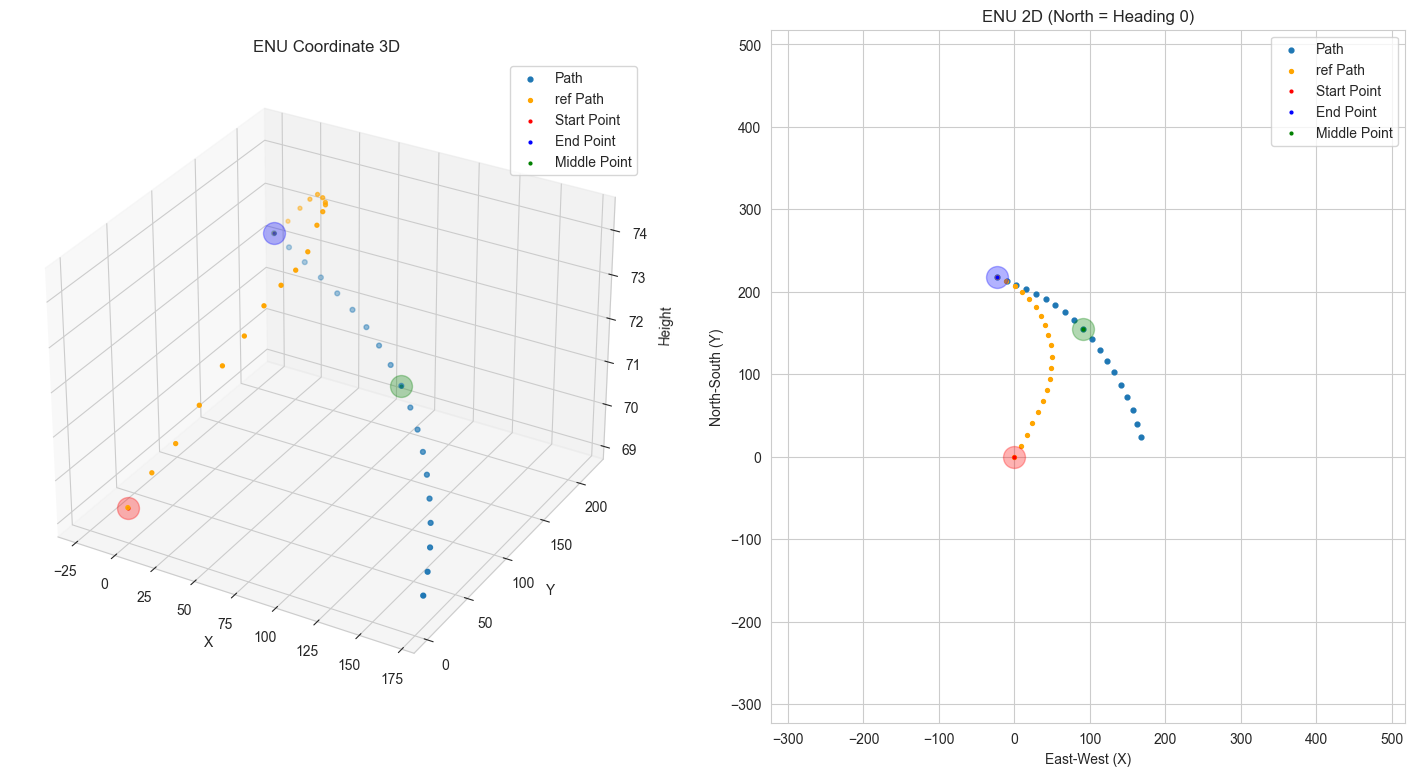

Height diff as 2.6559999999999917   estimated as 2.7463734860862274
Speed diff as -3.2059999999999995   estimated as -2.587576533530358
Heading diff as 4.511624280126558   estimated as -1.7804570185083894
Slope diff as -0.07774181235912922   estimated as 0.010439790554831933
X diff as -22.67601857279256   estimated as -45.68853997290875
Y diff as 217.73854193560572   estimated as 225.7210045906973
start heading : 0.552809478624302 X : 0.0 Y : 0.0 height : 69.528 slope : 0.041338966113281146 speed : 16.029
end heading : 5.06443375875086 X : -22.67601857279256 Y : 217.73854193560572 height : 72.184 slope : -0.03640284624584807 speed : 12.823
estimated end heading : -1.2276475398840874 X : -45.68853997290875 Y : 225.7210045906973 height : 72.27437348608623 slope : 0.010439790554831933 speed : 13.441423466469642
--------------------
x diff as [ 2.65765011  4.55967874  5.47267198  5.34828073  4.27092043  2.49652571
  0.58497814  1.42366214  3.64726504  6.05422586  8.52626923 10.84405063
 12

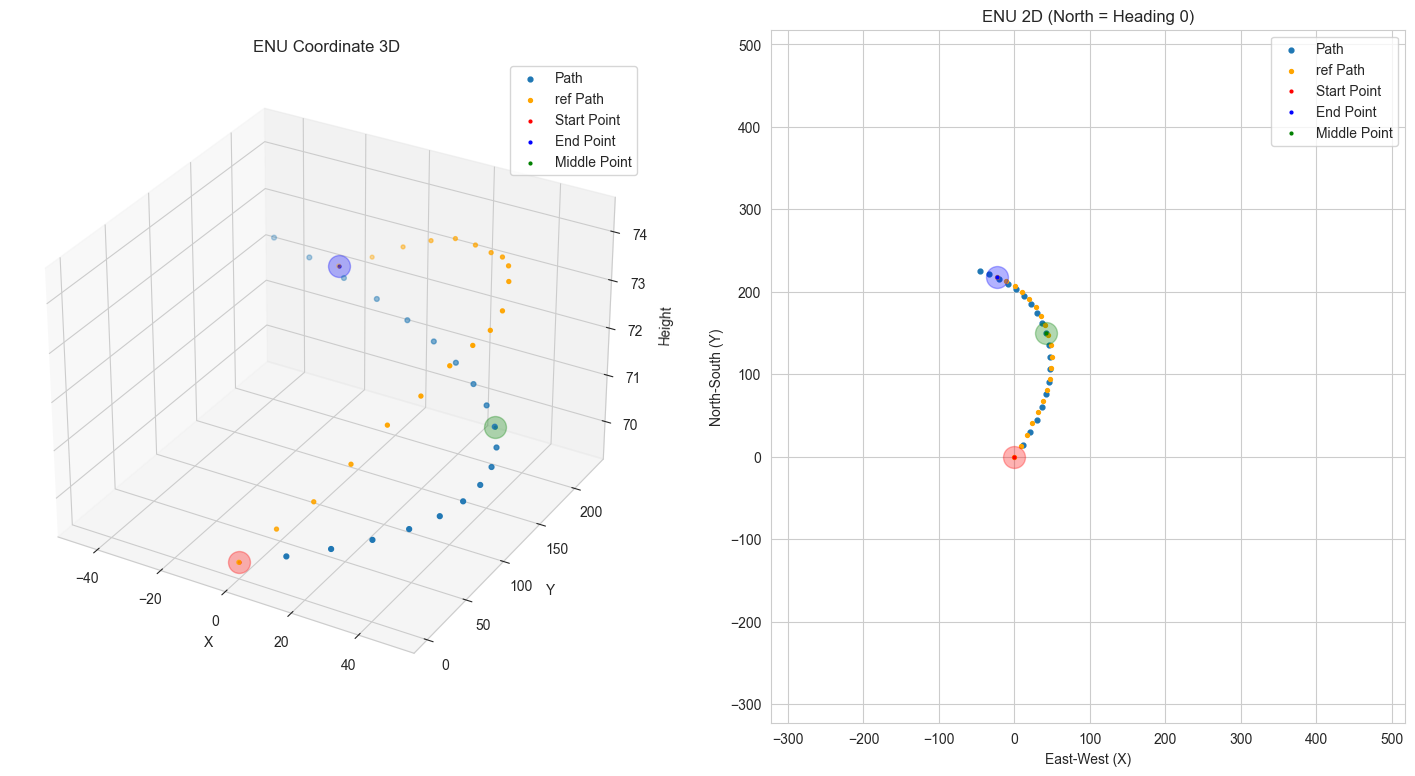

Lat: 37.566500, Lon: 37.566550, h: 37.57
Lat: 126.978000, Lon: 126.978126, h: 126.98
Lat: 0.000000, Lon: 1.111123, h: 2.22


In [16]:
from pyproj import Geod

# 이미 calibration 된 데이터에서 initailize한 한부분을 df로 받음
def initialize(df, linear_slope=True, reverse = False):

    df["TimeStamp"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df["UnixTime"] = df["TimeStamp"].apply(lambda x: x.timestamp())

    data = np.array([tuple(x) for x in np.vstack( \
                (df['UnixTime'], \
                    df['numSV'], \
                    df['height'], \
                    df['Speed'], \
                    df['AccelX'], \
                    df['AccelY'], \
                    df['AccelZ'], \
                    df['AngleRateX'], \
                    df['AngleRateY'], \
                    df['AngleRateZ'], \
                    df["headMot"], \
                    df["lat"], \
                    df["lon"],
                    )).T], \

                dtype = [('TimeStamp', None), \
                        ('numSV', None), \
                        ('Height', None), \
                        ('Speed', None), \
                        ('AccelX', None), \
                        ('AccelY', None), \
                        ('AccelZ', None), \
                        ('AngleRateX', None), \
                        ('AngleRateY', None), \
                        ('AngleRateZ', None), \
                        ('Heading', None),  \
                        ('Lat', None), \
                        ('Lon', None),
                        ])

    # 변화량은 소문자로 표기, 합친 값은 대문자로 표기기
    delta_p = {
        "heading": np.zeros(len(data)-1),
        "Slope" :  np.zeros(len(data)-1),
        "speed" :  np.zeros(len(data)-1),
        "x" : np.zeros(len(data)-1),
        "y" :  np.zeros(len(data)-1),
        "height" :  np.zeros(len(data)-1),
    }

    # 원통형 좌표계로 start_point, end_point 변환

    geod = Geod(ellps="WGS84")

    time_delta = np.diff(data["TimeStamp"])
    #time_delta = np.insert(time_delta, 0, time_delta[0])[:-1]

    dt = data.dtype.descr.copy()
    dt.append(('Slope', '<f8'))
    dt.append(('X', '<f8'))
    dt.append(('Y', '<f8'))

    start_point = data[0].copy()
    end_point = data[-1].copy()

    start_point = np.zeros(1, dtype=dt)[0]
    end_point = np.zeros(1, dtype=dt)[0]

    for name in data.dtype.names:
        start_point[name] = data[name][0]
        end_point[name] = data[name][-1]

    start_point["Slope"] = np.arctan2((data["Height"][1] - data["Height"][0]), (data["Speed"][0] * time_delta[0]))
    end_point["Slope"] = np.arctan2((data["Height"][-1] - data["Height"][-2]), (data["Speed"][-1] * time_delta[-1]))

    azimuth, _, distance = geod.inv(start_point["Lon"], start_point["Lat"], end_point["Lon"], end_point["Lat"])
    azimuth_rad = np.radians(azimuth)


    start_point["X"] = 0
    end_point["X"] = distance * np.sin(azimuth_rad)
    start_point["Y"] = 0
    end_point["Y"] =  distance * np.cos(azimuth_rad)

    # initialize 하기 전에 각속도는 일단 MA 쳐야함. 마지막의 None 값은 data의 값 그대로 사용
    window_size_yaw = 5
    window_size_pitch = 10
    window_size_accel = 1

    def ma_concat(data, ma, window_size):
        data_MA = np.full(len(data), np.nan)

        # 시작과 끝 부분 처리
        data_MA[-(window_size):] = data[-(window_size):] / window_size
        data_MA[:-(window_size)] = ma[:-(window_size)]

        return data_MA

    # Heading diff = - Yaw Rate, window 1로 그대로 사용
    Yaw_MA = -np.roll(df["AngleRateZ"].rolling(window_size_yaw).mean(), -window_size_yaw).copy()
    Yaw_MA = ma_concat(data["AngleRateZ"], Yaw_MA, window_size_yaw)[:-1]

    # Slope ~ Pitch Rate
    Pitch_MA = np.roll(df["AngleRateY"].rolling(window_size_pitch).mean(), -window_size_pitch).copy() / window_size_pitch
    Pitch_MA = ma_concat(data["AngleRateY"], Pitch_MA, window_size_pitch)[:-1]

    Accx_MA = np.roll(df["AccelX"].rolling(window_size_accel).mean(), -window_size_accel).copy()
    Accx_MA = ma_concat(data["AccelX"], Accx_MA, window_size_accel)[:-1]

    Accy_MA = np.roll(df["AccelY"].rolling(window_size_accel).mean(), -window_size_accel).copy()
    Accy_MA = ma_concat(data["AccelY"], Accy_MA, window_size_accel)[:-1]

    if reverse:
        start_point, end_point = end_point.copy(), start_point.copy()

        # radius 축을 North로 잡으면 theta 둘 필요 없음. 사용하고 있지 않기도 함.
        # start_point["X"] = 0
        # end_point["X"] = distance
        # start_point["Y"] = 0
        # end_point["Y"] =  - (end_point["Heading"] - start_point["Heading"])

        for point in [start_point, end_point]:
            point["Heading"] = point["Heading"] + np.pi
            point["Slope"] = - point["Slope"]

        Yaw_MA = np.flip(Yaw_MA)
        Pitch_MA = np.flip(Pitch_MA)
        Accx_MA = np.flip(Accx_MA)
        time_delta = np.flip(time_delta)

    def init_heading(heading_array, Yaw_MA, time_delta):
        heading_array[:] = Yaw_MA/80 * time_delta
        if reverse:
            heading_array[:] = - Yaw_MA/80 * time_delta
        return heading_array

    def init_heading_by_accy(heading_array, Accy_MA, speed_array, time_delta, k = 1):
            Speed_array = start_point["Speed"] + np.cumsum(speed_array)
            heading_array[:] = - Accy_MA * time_delta / (k * Speed_array)
            if reverse:
                heading_array[:] = - heading_array
            return heading_array

    def init_slope(slope_array, Pitch_MA, time_delta):
        """
        pitch rate로는 slope 를 파악하기 어려워 해당 함수 사용안함
        """
        slope_array[:] = Pitch_MA #* time_delta
        if reverse:
            slope_array[:] = - Pitch_MA #* time_delta
        slope_array = np.diff(slope_array)
        slope_array = np.insert(slope_array, 0, 0)

        return slope_array

    def init_speed(start_point, speed_array, Accx_MA, slope_array, time_delta):
        Slope_array = slope_array #start_point["Slope"] + np.cumsum(slope_array)
        if not reverse:
            speed_array[:] = (Accx_MA - 9.814 * np.sin(Slope_array)) * np.cos(Slope_array) * time_delta
        else :
            speed_array[:] = - (Accx_MA - 9.814 * np.sin(-Slope_array)) * np.cos(-Slope_array) * time_delta
        return speed_array

    def init_height(start_point, height_array, speed_array, slope_array, time_delta):

        Slope_array = slope_array #start_point["Slope"] + np.cumsum(slope_array)
        Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        height_array[:] = Speed_array * np.tan(Slope_array) * np.abs(time_delta)

        return height_array

    def init_x_y(start_point, x_array, y_array, speed_array, heading_array, time_delta):
        Speed_array = start_point["Speed"] + np.cumsum(speed_array)
        Heading_array = start_point["Heading"] + np.cumsum(heading_array)
        x_array[:] = Speed_array * np.sin(Heading_array) * time_delta
        y_array[:] = Speed_array * np.cos(Heading_array) * time_delta

        return x_array, y_array

    def now_value(array, idx):
        sum_array = array.cumsum()
        return sum_array[idx]


    delta_p["heading"] = init_heading(delta_p["heading"], Yaw_MA, time_delta)

     # 단순 끝점 간 고도 차로 linear 하게 초기 slope 생성, delta slope는 전부 0으로 초기화. slope_s를 해당 slope 값으로 설정
    if linear_slope == True:
        delta_p["Slope"] = np.arctan2(end_point["Height"] - start_point["Height"], start_point["Speed"] * np.sum(time_delta))*np.ones(len(data)-1)
    else:
        delta_p["Slope"] = init_slope(delta_p["Slope"], Pitch_MA, time_delta)
    delta_p["speed"] = init_speed(start_point, delta_p["speed"], Accx_MA, delta_p["Slope"], time_delta)
    delta_p["heading"] = init_heading_by_accy(delta_p["heading"], Accy_MA, delta_p["speed"], time_delta)
    delta_p["height"] = init_height(start_point, delta_p["height"], delta_p["speed"], delta_p["Slope"], time_delta)
    delta_p["x"], delta_p["y"] = init_x_y(start_point, delta_p["x"], delta_p["y"], delta_p["speed"], delta_p["heading"], time_delta)

    return start_point, end_point, delta_p, time_delta

def bi_direction(s, e, delta_s, delta_e, alpha = 2):
    # 양방향으로 초기 값 생성하고, 내분해서 최종 초기화
    path_s = {}
    path_e = {}
    path_bi = {}

    delta_e_s = {}
    delta_bi = {}

    N_ = len(delta_s["heading"]) + 1
    t_values = np.linspace(alpha/(N_), (N_-alpha)/(N_), N_) #np.linspace(1/(N_+1), N_/(N_+1), N_)

    # t_values = np.linspace(0 + 0.2, np.pi - 0.2, N_)
    # t_values = (1 - np.cos(t_values)) / 2

    s["Heading"] = s["Heading"] % (2 * np.pi)

    e_e = e.copy()
    e_e["Heading"] = e["Heading"] + np.pi

    for col, delta_col in zip(["Height", "Speed", "Heading", "X", "Y"],
                ["height", "speed", "heading", "x", "y"]):
        path_s[col] = s[col] + np.cumsum(delta_s[delta_col])
        path_e[col] = (e_e[col] + np.cumsum(delta_e[delta_col]))[::-1]

    path_s["Slope"] = delta_s["Slope"]
    path_e["Slope"] = delta_e["Slope"]

    for col in ["Height", "Speed", "Heading", "X", "Y", "Slope"]:
        path_s[col] = np.insert(path_s[col], 0, s[col])
        path_e[col] = np.append(path_e[col], e_e[col])


    path_e_s = path_e.copy()
    path_e_s["Heading"] = path_e_s["Heading"] - np.pi
    path_e_s["Slope"] = - path_e_s["Slope"]

    # display(path_e_s["Heading"])
    # display(path_s["Heading"])

    def head(x, y):
        azimuth = np.arctan(x/y)
        if azimuth < 0 :
            azimuth += np.pi

        if x < 0 :
            azimuth += np.pi

        return azimuth


    for col, delta_col in zip(["Height",  "X", "Y", "Heading",],
                ["height", "x", "y", "heading",]):
        if col != "Heading":
            path_bi[col] = (1 - t_values) * path_s[col]  + t_values * path_e_s[col]
        else:

            x = np.diff(path_bi["X"])
            y = np.diff(path_bi["Y"])

            smooth_heading = np.array([head(x_, y_) for x_,y_ in zip(x, y)])

            smooth_heading = smooth_heading % (2 * np.pi)
            # display(smooth_heading)

            path_bi[col] = np.insert(smooth_heading, 0, s["Heading"])

    for col, delta_col in zip(["Height", "Heading", "X", "Y", "Speed", "Slope",  ],
                ["height", "heading", "x", "y", "speed", "Slope",  ]):

        if (col != "Slope") and (col != "Speed"):
            delta_bi[delta_col] = np.diff(path_bi[col]) #
            delta_e_s[delta_col] = np.diff(path_e_s[col])
        elif (col == "Slope"):
            delta_bi[delta_col] = np.arctan2(delta_bi["height"], (s["Speed"] + np.cumsum(delta_bi["speed"] + 1e-10)))
            delta_e_s[delta_col] = np.arctan2(delta_e_s["height"], (s["Speed"] + np.cumsum(delta_e_s["speed"] + 1e-10)))
        else :

            delta_bi[delta_col] = np.diff(np.insert(np.sqrt(delta_bi["y"] **2 + delta_bi["x"]**2), 0, s[col]))
            delta_e_s[delta_col] = np.diff(np.insert(np.sqrt(delta_bi["y"] **2 + delta_bi["x"]**2), 0, s[col]))

    # delta_e_s의 경우 초기 값이 e -> s기준으로 변환된 좌표계에서의 s 예측값이므로, s와 다름
    # 이를 보정해주기 위해 s 기준으로 변환된 s 예측값 성분 - s 성분을 더해, s 성분에 해당 초기값 더하면 올바른 경로 생성되도록 함.
    for col, delta_col in zip(["Height", "Heading", "X", "Y", "Speed", "Slope",  ],
                ["height", "heading", "x", "y", "speed", "Slope", ]):
        delta_e_s[delta_col][0] += (path_e_s[col][0] - s[col])

    delta_bi["heading"] = np.unwrap(delta_bi["heading"])
    delta_e_s["heading"] = np.unwrap(delta_e_s["heading"])

    return  path_bi, path_e_s, delta_bi, delta_e_s


%matplotlib inline
def visuallize(s, e, delta_p, ref_GPS = None):
    geod = Geod(ellps="WGS84")
    def r_cal(lat, lon):
        azimuth, _, distance = geod.inv(s["Lon"], s["Lat"], lon, lat)
        return [np.radians(azimuth), distance]

    if ref_GPS is None:
        pass
    else:
        r_cal_ = [r_cal(lat, lon) for lat, lon in zip(np.array(ref_GPS["lat"]), np.array(ref_GPS["lon"]))]
        ref_numSV = np.array(ref_GPS["numSV"])
        ref_theta = np.array([r_cal[0] for r_cal in r_cal_])
        ref_radius = np.array([r_cal[1] for r_cal in r_cal_])
        ref_height = np.array(ref_GPS["height"])
        ref_speed = np.array(ref_GPS["Speed"])
        ref_heading = np.array(ref_GPS["headMot"])
        ref_x = ref_radius * np.sin(ref_theta)
        ref_y = ref_radius * np.cos(ref_theta)
        ref_z = ref_height


    for col, delta_col in zip(["Height", "Speed", "Heading", "Slope", "X", "Y",],
                ["height", "speed", "heading", "Slope", "x", "y", ]):
        if col not in ["Slope"]:
            print(col, "diff as", e[col] - s[col], " ", "estimated as", np.sum(delta_p[delta_col]))
        else:
            print(col, "diff as", e[col] - s[col], " ", "estimated as", delta_p[delta_col][-1])

    print("start", f"heading : {s['Heading']}", f"X : {s['X']}", f"Y : {s['Y']}", f"height : {s['Height']}", f"slope : {s['Slope']}", f"speed : {s['Speed']}",)
    print("end", f"heading : {e['Heading']}", f"X : {e['X']}", f"Y : {e['Y']}", f"height : {e['Height']}", f"slope : {e['Slope']}", f"speed : {e['Speed']}",)
    print("estimated end", f"heading : {s['Heading'] + np.sum(delta_p['heading'])}", f"X : {s['X'] + np.sum(delta_p['x'])}", f"Y : {s['Y'] + np.sum(delta_p['y'])}", f"height : {s['Height']+ np.sum(delta_p['height'])}", f"slope : {delta_p['Slope'][-1]}", f"speed : {s['Speed']+ np.sum(delta_p['speed'])}",)

    x = s["X"] + np.cumsum(delta_p["x"])
    y = s["Y"] + np.cumsum(delta_p["y"])
    z = s["Height"] + np.cumsum(delta_p["height"])
    head = s["Heading"] + np.cumsum(delta_p["heading"])
    speed = s["Speed"] + np.cumsum(delta_p["speed"])

    if ref_GPS is not None:
        print("--------------------")

        normal_idx = np.where(ref_numSV[:-1] > 0)
        x_diff = np.sqrt((ref_x[1:][normal_idx] - x[normal_idx])**2)
        y_diff = np.sqrt((ref_y[1:][normal_idx] - y[normal_idx])**2)
        z_diff = np.sqrt((ref_z[1:][normal_idx] - z[normal_idx])**2)
        speed_diff = np.sqrt((ref_speed[1:][normal_idx] - speed[normal_idx])**2)
        # display(ref_heading)
        # display(head)
        head_diff = np.sqrt(((ref_heading[1:] - head) % (2*np.pi))** 2)
        head_diff = np.abs((head_diff + np.pi) % (2 * np.pi) - np.pi )

        x_diff = x_diff[~np.isnan(x_diff)]
        y_diff = y_diff[~np.isnan(y_diff)]
        r_diff = np.sqrt(x_diff**2 + y_diff**2)
        z_diff = z_diff[~np.isnan(z_diff)]
        head_diff = head_diff[~np.isnan(head_diff)]
        speed_diff = speed_diff[~np.isnan(speed_diff)]

        print(f"x diff as {x_diff}")
        print(f"y diff as {y_diff}")
        print(f"r diff as {r_diff}")
        print(f"h diff as {z_diff}")
        print(f"speed diff as {speed_diff}")
        print(f"head diff as {head_diff}")

        print(f"avg x diff as {np.mean(x_diff)} m")
        print(f"avg y diff as {np.mean(y_diff)} m")
        print(f"avg r diff as {np.mean(r_diff)} m")
        print(f"avg h diff as {np.mean(z_diff)} m")
        print(f"avg speed diff as {np.mean(speed_diff)} m/s")
        print(f"avg heading diff as {np.mean(head_diff)} rad")


    s_x, s_y = s["X"], s["Y"]
    e_x, e_y = e["X"], e["Y"]

    m_idx = len(delta_p["height"]) // 2
    m_x, m_y, m_z = x[m_idx], y[m_idx], z[m_idx]

    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, s=12, label='Path')

    if ref_GPS is not None:
        ax.scatter(ref_x, ref_y, ref_z, s=8, color="orange", label='ref Path')

    ax.scatter(s_x, s_y,
            s["Height"],
            color='red', s=250, alpha=0.3)
    ax.scatter(e_x, e_y,
            e["Height"],
            color='blue', s=250, alpha=0.3)
    ax.scatter(m_x, m_y,
            m_z,
            color='green', s=250, alpha=0.3)

    ax.scatter(s_x, s_y,
            s["Height"],
            color='red', s=4, label='Start Point')
    ax.scatter(e_x, e_y,
            e["Height"],
            color='blue', s=4, label='End Point')
    ax.scatter(m_x, m_y,
            m_z,
            color='green', s=4, label='Middle Point')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height')
    ax.set_title('ENU Coordinate 3D')
    ax.legend()

    az = fig.add_subplot(122)

    az.scatter(x, y, label='Path', s = 12)
    if ref_GPS is not None:
        az.scatter(ref_x, ref_y, s=8, color="orange", label='ref Path')

    az.scatter(s_x, s_y, color='red', s=250, alpha=0.3)
    az.scatter(e_x, e_y, color='blue', s=250, alpha=0.3)
    az.scatter(m_x, m_y, color='green', s=250, alpha=0.3)
    az.scatter(s_x, s_y, color='red', s=4, label='Start Point')
    az.scatter(e_x, e_y, color='blue', s=4, label='End Point')
    az.scatter(m_x, m_y, color='green', s=4, label='Middle Point')
    az.set_title('ENU 2D (North = Heading 0)')
    az.set_xlabel('East-West (X)')
    az.set_ylabel('North-South (Y)')

    # 그래프 크기 고정 (500x500)
    min_ = min(s_x, e_x, s_y, e_y)
    max_ = max(s_x, e_x, s_y, e_y)
    az.set_xlim(min_ - 300, max_+300)
    az.set_ylim(min_ - 300, max_+300)
    az.grid(True)
    az.legend()

    plt.show()


data_ = result[0]
data_ = acc_file[2530:2550].copy()
s, e, delta_s, time_delta_s = initialize(data_, linear_slope=True)
ss, ee, delta_e, time_delta_e = initialize(data_, reverse=True, linear_slope=True)

path_bi, path_e_s, delta_bi, delta_e_s = bi_direction(s, e, delta_s, delta_e, alpha=4)

visuallize(s, e, delta_s, data_[["lat", "lon", "headMot", "height", "Speed", "numSV"]])
visuallize(s, e, delta_e_s, data_[["lat", "lon", "headMot", "height", "Speed","numSV"]])
visuallize(s, e, delta_bi, data_[["lat", "lon", "headMot", "height", "Speed","numSV"]])

import numpy as np

# 지구 타원체 파라미터 (WGS84)
a = 6378137.0               # semi-major axis (m)
e2 = 6.69437999014e-3        # eccentricity squared


def geodetic_to_ecef(lat, lon, h):
    """
    지리 좌표 (lat, lon, h)를 ECEF 좌표 (x, y, z)로 변환 (WGS84 기준)
    lat, lon: degree 단위
    h: 고도 (m)
    """
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    N = a / np.sqrt(1 - e2 * np.sin(lat_rad)**2)
    x = (N + h) * np.cos(lat_rad) * np.cos(lon_rad)
    y = (N + h) * np.cos(lat_rad) * np.sin(lon_rad)
    z = ((1 - e2) * N + h) * np.sin(lat_rad)
    return np.array([x, y, z])

def ecef_to_geodetic(x, y, z):
    """
    ECEF 좌표 (x, y, z)를 지리 좌표 (lat, lon, h)로 변환 (WGS84 기준)
    반환: (lat, lon, h) [lat, lon in degrees, h in meters]
    """
    b = a * np.sqrt(1 - e2)
    ep = np.sqrt((a**2 - b**2)/b**2)
    p = np.sqrt(x**2 + y**2)
    th = np.arctan2(a * z, b * p)
    lon = np.arctan2(y, x)
    lat = np.arctan2(z + ep**2 * b * np.sin(th)**3, p - e2 * a * np.cos(th)**3)
    N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
    h = p / np.cos(lat) - N
    return np.degrees(lat), np.degrees(lon), h

def enu_to_ecef(e, n, u, ref_lat, ref_lon, ref_h):
    """
    ENU 좌표 (e, n, u)를 ECEF 좌표로 변환.
    ref_lat, ref_lon, ref_h: 기준점의 지리 좌표 (degree, degree, m)
    """
    # 기준점의 ECEF 좌표
    ref_ecef = geodetic_to_ecef(ref_lat, ref_lon, ref_h)
    # 기준점의 위도/경도를 radian으로
    lat0 = np.radians(ref_lat)
    lon0 = np.radians(ref_lon)
    # ENU -> ECEF 회전 행렬 (East, North, Up 순)
    R = np.array([[-np.sin(lon0),              np.cos(lon0),             0],
                  [-np.sin(lat0)*np.cos(lon0), -np.sin(lat0)*np.sin(lon0),  np.cos(lat0)],
                  [ np.cos(lat0)*np.cos(lon0),  np.cos(lat0)*np.sin(lon0),  np.sin(lat0)]])
    enu = np.array([e, n, u])
    # ECEF 좌표: 기준점 + 회전 행렬의 전치 * enu 벡터
    ecef = ref_ecef + R.T.dot(enu)
    return ecef

def local_path_to_geodetic(x, y, h, ref):
    """
    로컬 좌표계 (x, y, h)로 구성된 경로를 지리 좌표 (lat, lon, h)로 변환.
    ref: 기준점 사전 (예: {"lat": ..., "lon": ..., "h": ...})
         이 기준점은 로컬 좌표계의 원점으로 가정.

    x, y, h: 각각 N개의 점으로 구성된 배열 (예: np.array)
    반환: (lat, lon, h) 좌표 배열 (N x 3)
    """
    ref_lat = ref["Lat"]
    ref_lon = ref["Lon"]
    ref_h = ref["Height"]
    lat_list, lon_list, height_list = [], [], []

    for xi, yi, hi in zip(x, y, h):
        # 여기서 x는 동쪽(East), y는 북쪽(North)으로 가정
        ecef = enu_to_ecef(xi, yi, hi, ref_lat, ref_lon, ref_h)
        lat, lon, alt = ecef_to_geodetic(ecef[0], ecef[1], ecef[2])
        lat_list.append(lat)
        lon_list.append(lon)
        height_list.append(alt)

    return np.array(lat_list), np.array(lon_list), np.array(height_list)

def recover_visuallize(s, delta_bi, data=None, show= True):
    lat_rec, lon_rec, h_rec = local_path_to_geodetic(np.cumsum(delta_bi["x"]), np.cumsum(delta_bi["y"]), np.cumsum(delta_bi["height"]), s)
    recovered_df = pd.DataFrame(np.hstack([lat_rec.reshape(-1, 1), lon_rec.reshape(-1, 1), h_rec.reshape(-1, 1)]), columns=["lat", "lon", "height"])

    #display(recovered_df)
    if show:
        fig = go.Figure()
        fig.add_trace(go.Scattermapbox(
            lat=recovered_df['lat'],
            lon=recovered_df['lon'],
            mode='markers+lines',
            marker=dict(size=10, color='firebrick'),
            name='Recovered Path'
        ))

        if data is not None:
            fig.add_trace(go.Scattermapbox(
                lat=data['lat'],
                lon=data['lon'],
                mode='markers+lines',
                marker=dict(size=10, color='royalblue'),
                name='Original Path'
            ))

        fig.update_layout(
            mapbox=dict(
                style="open-street-map",
                zoom=15,
                center=dict(lat=recovered_df['lat'].iloc[0], lon=recovered_df['lon'].iloc[0])
            ),
            width=1200,
            height=900,
            margin=dict(l=0, r=0, t=0, b=0),
            showlegend=True,
            legend=dict(
                x=0.05,  # Adjust the x-coordinate (0 is left, 1 is right)
                y=0.95,  # Adjust the y-coordinate (0 is bottom, 1 is top)
                bgcolor='rgba(255, 255, 255, 0.9)', # Optional: Add a background for better readability
                bordercolor='black', # Optional: Add a border
                borderwidth=1 # Optional: Adjust border width
            )
        )

        fig.show()

    return recovered_df

if __name__ == '__main__':
    # 기준점: 시작점의 geodetic 좌표 (예: 서울 시청)
    ref = {"Lat": 37.5665, "Lon": 126.9780, "Height": 0.0}

    # 예시 로컬 경로 (x, y, h) -- 단위: 미터
    # 예를 들어, x는 동쪽, y는 북쪽, h는 고도 변화
    N = 10
    # 간단한 직선 경로 예: x는 0에서 100 m, y는 0에서 50 m, h는 0에서 10 m 변화
    x = np.linspace(0, 100, N)
    y = np.linspace(0, 50, N)
    h = np.linspace(0, 10, N)

    geodetic_path = local_path_to_geodetic(x, y, h, ref)

    # 결과 출력: 각 점의 (lat, lon, h)
    for pt in geodetic_path:
        print("Lat: {:.6f}, Lon: {:.6f}, h: {:.2f}".format(pt[0], pt[1], pt[2]))

,del_X,del_Y,height,Speed,headMot
count,26169.000000,26169.000000,26168.000000,26168.000000,26168.000000
mean,11.565702,17.266648,0.475551,0.349179,0.052488
std,7.432796,9.034984,1.218169,0.490484,0.399856
min,0.000554,0.000058,0.000000,0.000000,0.000000
25%,5.387023,9.647531,0.147000,0.084000,0.003094
50%,11.177205,18.139730,0.336000,0.195000,0.010963
75%,16.945022,25.842273,0.638000,0.427000,0.028873
max,30.067404,30.229993,85.980000,17.253000,6.281484


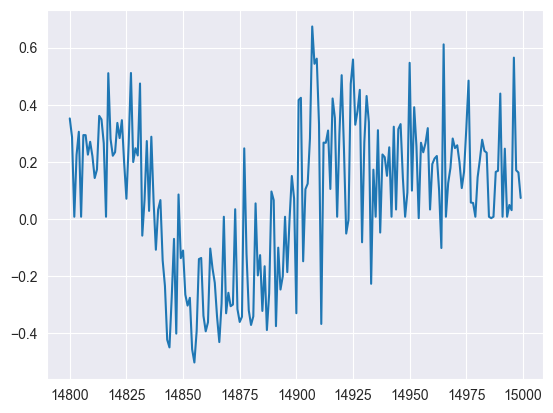

In [38]:
plt.plot(acc_file["AccelX"][14800:15000])

acc_file_int = acc_file.loc[(acc_file["numSV"] > 10) & (acc_file["height"] > 0) & (acc_file["height"] < 1000) & (acc_file["Speed"] > 0)].copy()
acc_file_int["del_X"] = np.abs(acc_file_int["Speed"] * np.sin(acc_file_int["headMot"]))
acc_file_int["del_Y"] = np.abs(acc_file_int["Speed"] * np.cos(acc_file_int["headMot"]))
acc_file_int["headMot"] = np.abs(acc_file_int['headMot'].diff()) #% (np.pi * 2)
acc_file_int["height"] = np.abs(acc_file_int['height'].diff())
acc_file_int["Speed"] = np.abs(acc_file_int['Speed'].diff())

acc_file_int[["del_X", "del_Y", "height", "Speed", "headMot",]].describe()

In [39]:

class optimizer():
    def __init__(self, s, e, delta, time_delta = None, epsilon = 1e-3, max_iter = 30):

        self.s = s
        print(self.s)
        self.e = e
        self.e_true = np.array([
        (self.e["Heading"]) , #% (2 * np.pi)
        self.e["Speed"],
        self.e["Height"],
        self.e["X"],
        self.e["Y"]
        ])

        self.m = int(len(delta["heading"]) * 6)
        self.N = int(self.m // 6)
        self.mu = 10 * np.ones(self.m)
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.weight = np.array([3*1e-2, 10, 10, 3, 3]) # heading, speed, height, X, Y
        self.min_turn_R = 25

        self.DV = np.vstack([delta["heading"].reshape(-1, 1), delta["Slope"].reshape(-1, 1), delta["speed"].reshape(-1, 1)]).flatten()
        self.org_slope = delta["Slope"].reshape(-1, 1).flatten()
        self.org_heading = delta["heading"].reshape(1, -1).flatten()

        if time_delta is None:
            self.time_delta = np.ones(self.N)
        else:
            self.time_delta = time_delta

        self.grad_g = self.grad_g(self.N)
        self.tau = self.compute_tau()

    def grad_g(self, N):
        I = np.eye(N)
        Z = np.zeros((N, N))
        Z_s = Z[1:, :]
        I_s = np.vstack([np.zeros((1, N)), I[1:, :]])
        L = np.vstack([np.zeros((1, N)), np.tril(np.ones((N, N)))[1:, :]])
        R = self.min_turn_R
        M = np.block([
        [  Z,   I,   Z ],
        [ -Z,   I,   Z ],
        [  I_s,   Z,  -L/R ],
        [  I_s,  -Z,  -L/R ],
        [  Z,   Z,   I_s ],
        [  Z,   Z,  -I_s ]
        ])

        return M

    def cost_cal(self, DV):
        """
        s 기준 e 예측값과 e 간의 weighted 차이 계산
        """
        dv_heading = DV[:self.N]
        dv_slope = DV[self.N:2*self.N]
        dv_speed = DV[2*self.N:3*self.N]

        # 예측된 최종 값 계산
        Heading_cum = (self.s["Heading"] + np.cumsum(dv_heading)) #% (2 * np.pi)
        Speed_cum = self.s["Speed"] + np.cumsum(dv_speed)
        Speed_pred = Speed_cum[-1]
        Height_pred = self.s["Height"] + np.sum(Speed_cum * np.tan(dv_slope))

        X_pred = self.s["X"] + np.sum(Speed_cum * np.sin(Heading_cum))
        Y_pred = self.s["Y"] + np.sum(Speed_cum * np.cos(Heading_cum))

        e_true = self.e_true

        error_heading = np.cos(e_true[0])  - np.cos(Heading_cum[-1]) #% (2*np.pi)
        error_speed   = e_true[1] - Speed_pred
        error_height  = e_true[2] - Height_pred
        error_X  = e_true[3] - X_pred
        error_Y = e_true[4] - Y_pred


        w_heading, w_speed, w_height, w_x, w_y = self.weight

        cost_RH = 0.5 * ((error_heading / w_heading)**2 + (error_X/w_x)**2 + (error_Y/w_y)**2 ) #
        cost_SH = 0.5 * ((error_height / w_height)**2 + (error_speed /w_speed)**2 ) #

        error_RH_norm = np.sqrt(error_heading**2 + (error_X)**2 + (error_Y)**2)

        delta_thresh = 10
        gamma = 3

        if error_RH_norm > delta_thresh:
            adaptive_factor = 1.0 + gamma * (error_RH_norm - delta_thresh)
        else:
            adaptive_factor = 1.0

        lambda_slope = 1.0
        cost_slope = 0.5 * lambda_slope * np.sum((dv_slope - self.org_slope.flatten())**2) / self.N

        total_cost =  adaptive_factor * cost_RH + cost_SH #+ cost_slope


        return total_cost

    def constraint_cal(self, DV, R = 50, slope_ths = 0.1, acc_ths = 3):
        """
        제약조건 식 계산하기, 6N x 1
        """
        heading = DV[0:self.N]
        Slope = DV[self.N : 2 * self.N]
        speed = DV[2*self.N : 3 * self.N]
        Speed = self.s["Speed"] + np.cumsum(speed)

        # 위에서 10m로 지정
        R = self.min_turn_R

        Slope_cst = np.vstack([
            (Slope - slope_ths * np.ones(self.N) ).flatten(),
            (-Slope - slope_ths * np.ones(self.N) ).flatten()
        ])

        heading_cst = np.vstack([
            np.insert((np.dot((heading - self.org_heading), self.time_delta) - Speed/R)[1:], 0, 0).flatten(),
            np.insert((np.dot((-heading + self.org_heading), self.time_delta) - Speed/R)[1:], 0, 0).flatten()
        ])

        speed_cst = np.vstack([
            (np.insert(speed[1:] - acc_ths, 0, 0)).flatten(),
            (np.insert(-speed[1:] - acc_ths, 0, 0)).flatten()
        ])

        return np.vstack([
          Slope_cst, heading_cst, speed_cst
        ]).flatten()

    def hessian_cal(self, DV = None, epsilon=1e-6):
        if DV is None:
            DV = self.DV

        x = np.asarray(DV, dtype=float)
        n = x.size
        hessian = np.zeros((n, n))

        # f(x) 값 (필요시 사용)
        fx = self.cost_cal(x)

        # 대각 성분 계산 (이중 중앙 차분)
        for i in range(n):
            x_forward = np.copy(x)
            x_backward = np.copy(x)
            x_forward[i] += epsilon
            x_backward[i] -= epsilon
            f_forward = self.cost_cal(x_forward)
            f_backward = self.cost_cal(x_backward)
            hessian[i, i] = (f_forward - 2 * fx + f_backward) / (epsilon ** 2)

        # 비대각 성분 계산 (혼합 편미분: 중앙 차분)
        for i in range(n):
            for j in range(i+1, n):
                x_pp = np.copy(x)
                x_pm = np.copy(x)
                x_mp = np.copy(x)
                x_mm = np.copy(x)
                # 두 변수에 대해 epsilon 만큼 변화
                x_pp[i] += epsilon; x_pp[j] += epsilon  # f(x_i+eps, x_j+eps)
                x_pm[i] += epsilon; x_pm[j] -= epsilon  # f(x_i+eps, x_j-eps)
                x_mp[i] -= epsilon; x_mp[j] += epsilon  # f(x_i-eps, x_j+eps)
                x_mm[i] -= epsilon; x_mm[j] -= epsilon  # f(x_i-eps, x_j-eps)

                f_pp = self.cost_cal(x_pp)
                f_pm = self.cost_cal(x_pm)
                f_mp = self.cost_cal(x_mp)
                f_mm = self.cost_cal(x_mm)

                # 중앙 차분 공식 (혼합 편미분)
                hess_ij = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon**2)
                hessian[i, j] = hess_ij
                hessian[j, i] = hess_ij  # Hessian은 대칭 행렬

        return hessian

    def jacobian_cal(self, DV = None, epsilon=1e-6):
        if DV is None:
            DV = self.DV

        x = np.asarray(DV, dtype=float)
        n = x.size
        jacobian = np.zeros((1, n))

        for i in range(n):
            x_forward = np.copy(x)
            x_backward = np.copy(x)
            x_forward[i] += epsilon
            x_backward[i] -= epsilon
            f_forward = self.cost_cal(x_forward)
            f_backward = self.cost_cal(x_backward)
            jacobian[0, i] = (f_forward - f_backward) / (2 * epsilon)

        return jacobian

    def compute_tau(self, DV = None):
        if DV is None:
            DV = self.DV

        g = self.constraint_cal(DV)
        tau =  - (np.dot(self.mu, g)) / self.m
        return tau

    def compute_residuals(self, DV = None):
        """
        primal residual, central residual 계산
        """
        if DV is None:
            DV = self.DV

        jacobian = self.jacobian_cal(DV)
        hessian = self.hessian_cal(DV)
        g = self.constraint_cal(DV)

        dual_residual = (jacobian + self.grad_g.T @ self.mu).reshape(-1, 1)
        central_residual = (g  + self.tau * np.ones(self.N * 6)).reshape(-1, 1)

        residuals_ = np.vstack([dual_residual, central_residual]).flatten()

        return residuals_, jacobian, hessian, g

    def compute_step(self, residuals, hessian, g):
        """
        newton step 계산, delta x, u 벡터 계산산
        """
        #residuals = self.compute_residuals()

        grad_residual = np.vstack([np.hstack([hessian, self.grad_g.T]),
                                   np.hstack([np.diag(self.mu) @ self.grad_g, np.diag(g)])])

        try:
            delta_x =  -grad_residual @ residuals #np.linalg.inv(grad_residual)
        except Exception as e:
            print("singular matrix")
            delta_x = np.linalg.pinv(grad_residual + 10e-6 * np.eye(self.N * 9)) @ -residuals

        return delta_x


    def backtracking_line_search(self, delta_x, residuals, alpha = 0.2, beta = 0.99):
        delta_DV = delta_x[:self.N * 3]
        delta_mu = delta_x[self.N * 3:self.N * 9]

        idx = np.where(delta_mu < 0)[0]
        if idx.size > 0:
            theta_candidate = np.min(-self.mu[idx] / delta_mu[idx])
            theta_ = min(1, theta_candidate)
        else:
            theta_ = 1.0

        constraint_match = False

        while not constraint_match:
            if np.all(self.constraint_cal(self.DV + theta_ * delta_DV) <= 0) :
                constraint_match = True
            else :
                theta_ *= beta
        #print("const match done")

        residuals_match = False
        org_cost = self.cost_cal(self.DV)

        while not residuals_match:
            new_DV = self.DV + theta_ * delta_DV
            new_cost = self.cost_cal(new_DV)
            # residuals_update, jacobian, hessian, g = self.compute_residuals()


            if new_cost <= (1 - alpha * theta_) * org_cost :  #np.linalg.norm(residuals)
                residuals_match = True
            else:
                theta_ *= beta
        #print("res match done")
        print(theta_)
        return theta_ #* (0.9 ** 10)

    def optimize(self):
        iter_ = 0

        while iter_ <= self.max_iter: #

            residuals_, jacobian, hessian, g = self.compute_residuals(self.DV)
            dual_norm = np.linalg.norm(residuals_[:self.N * 3])
            central_norm = np.linalg.norm(residuals_[self.N * 3:self.N * 9])
            cost_ = self.cost_cal(self.DV)

            print(f"iter {iter_}) dual res: {dual_norm}, central res: {central_norm}, cost: {cost_}")

            if  (dual_norm< 990) and (central_norm< 300) and (cost_ < 0.5):
                print(f"iter {iter_}: residual dual {dual_norm} central {central_norm}")
                print("residual lower than ths, end optimization")
                break

            delta_x = self.compute_step(residuals_, hessian, g)
            theta_ = self.backtracking_line_search(delta_x, residuals_)

            self.DV = self.DV + theta_ * delta_x[:self.N * 3]
            self.mu = self.mu + theta_ * delta_x[self.N * 3:self.N * 9]
            self.tau = self.compute_tau()


            iter_ += 1

        return self.DV


def opt_result(s, e, optimizer_, ref_GPS = None, show = True):

    new_DV = optimizer_.DV
    heading = new_DV[:optimizer_.N]
    Slope = new_DV[1 * optimizer_.N:2 * optimizer_.N]
    speed = new_DV[2 * optimizer_.N:3 * optimizer_.N]
    Heading = s["Heading"] + np.cumsum(heading)
    Speed = s["Speed"] + np.cumsum(speed)
    height = Speed * np.tan(Slope)
    x = Speed * np.sin(Heading)
    y = Speed * np.cos(Heading)

    delta_opt = {
        "heading" : heading,
        "Slope" : Slope,
        "speed" : speed,
        "height" : height,
        "x" : x,
        "y" : y
    }

    if ref_GPS is None:
        visuallize(s, e, delta_opt)
        recover_df = recover_visuallize(s, delta_opt, None, show)
    else:
        visuallize(s, e, delta_opt, ref_GPS)
        recover_df = recover_visuallize(s, delta_opt, ref_GPS, show)

    recover_df["Speed"] = Speed
    recover_df["Heading"] = Heading

    return recover_df


13831 13856
zero speed, detect as default distance
14810 14830
zero speed, detect as default distance
16039 16057
zero speed, detect as default distance
16231 16246
zero speed, detect as default distance
17437 17452
zero speed, detect as default distance
17625 17644
zero speed, detect as default distance
18880 18899
zero speed, detect as default distance
19479 19503
zero speed, detect as default distance
210105.985 m GPS Outage part removed
(1.72584794e+09, 25., 89.387, 18.749, -0.13195076, 0.00956189, 9.79577637, -0.17278609, 0.13044882, -0.31952376, 0.12088814, 36.5330542, 127.4304486, 0.00901357, 0., 0.)
Height diff as 6.825999999999993   estimated as 6.586094582324924
Speed diff as -3.286999999999999   estimated as 0.8117230029787308
Heading diff as 4.606613301067575   estimated as 4.70641885283979
Slope diff as -0.06438312290936153   estimated as 0.01030921260520102
X diff as -48.96722088485969   estimated as -29.406663326988024
Y diff as 63.8738480773231   estimated as 42.9740402

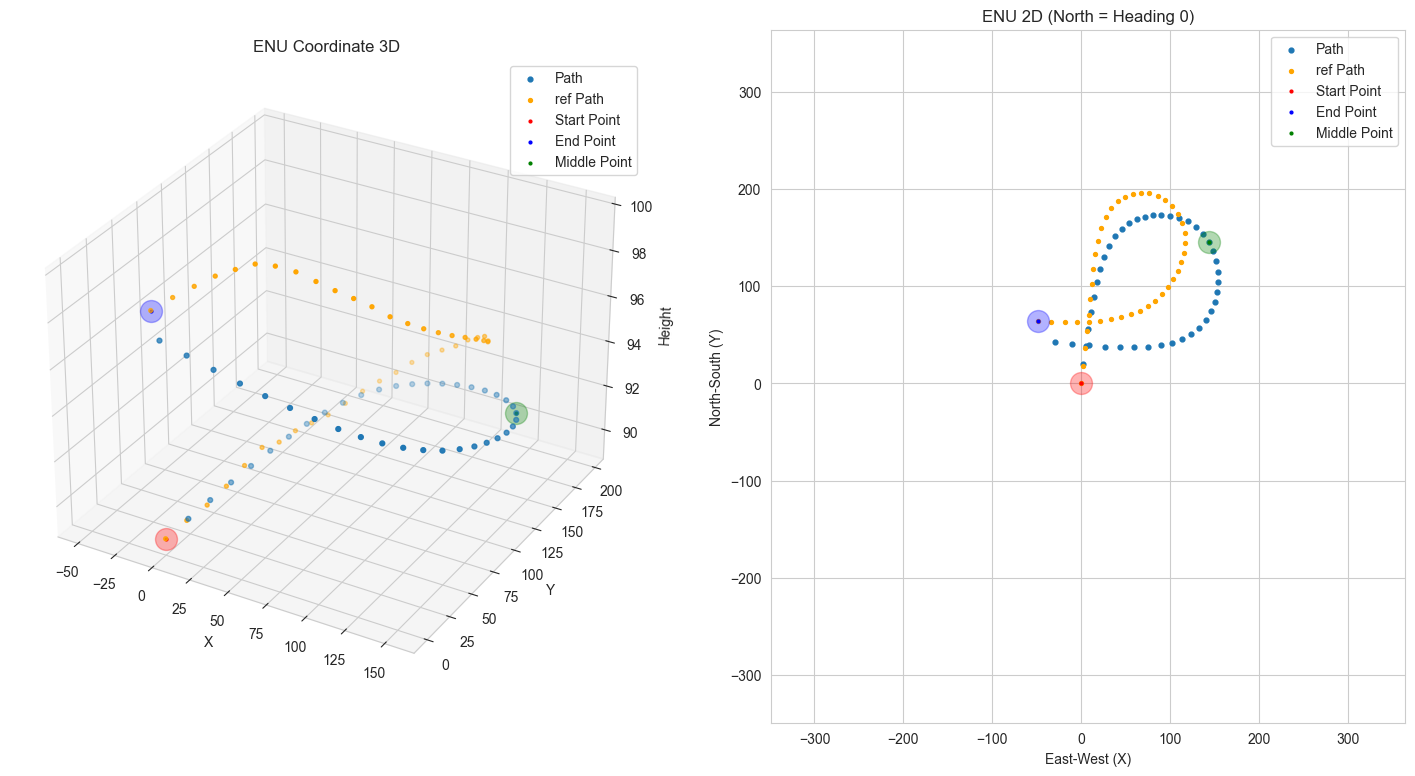

iter 0) dual res: 250781.36123566798, central res: 169.22761022952008, cost: 2902.4696246356607
1.0746766354163106e-14
iter 1) dual res: 343061.35646620544, central res: 169.238800732678, cost: 2758.0922174885427
6.245969344535075e-15
iter 2) dual res: 254155.8345664847, central res: 169.2243445410824, cost: 2707.911303729469
1.0345111562694133e-14
iter 3) dual res: 336900.8293940553, central res: 169.23298023580324, cost: 2570.0848133184318
6.551367858216664e-15
iter 4) dual res: 256024.01555999392, central res: 169.22045960585987, cost: 2553.411286988269
1.0099802356530587e-14
iter 5) dual res: 332687.0608796244, central res: 169.22659020503124, cost: 2485.153303231983
6.7546553748829315e-15
iter 6) dual res: 254375.7230145366, central res: 169.2159604103124, cost: 2399.2100310509163
1.00223307849669e-14
iter 7) dual res: 320774.4362812175, central res: 169.21954452709488, cost: 2334.6562911731967
7.0973853268702945e-15
iter 8) dual res: 247252.04271047484, central res: 169.210926170

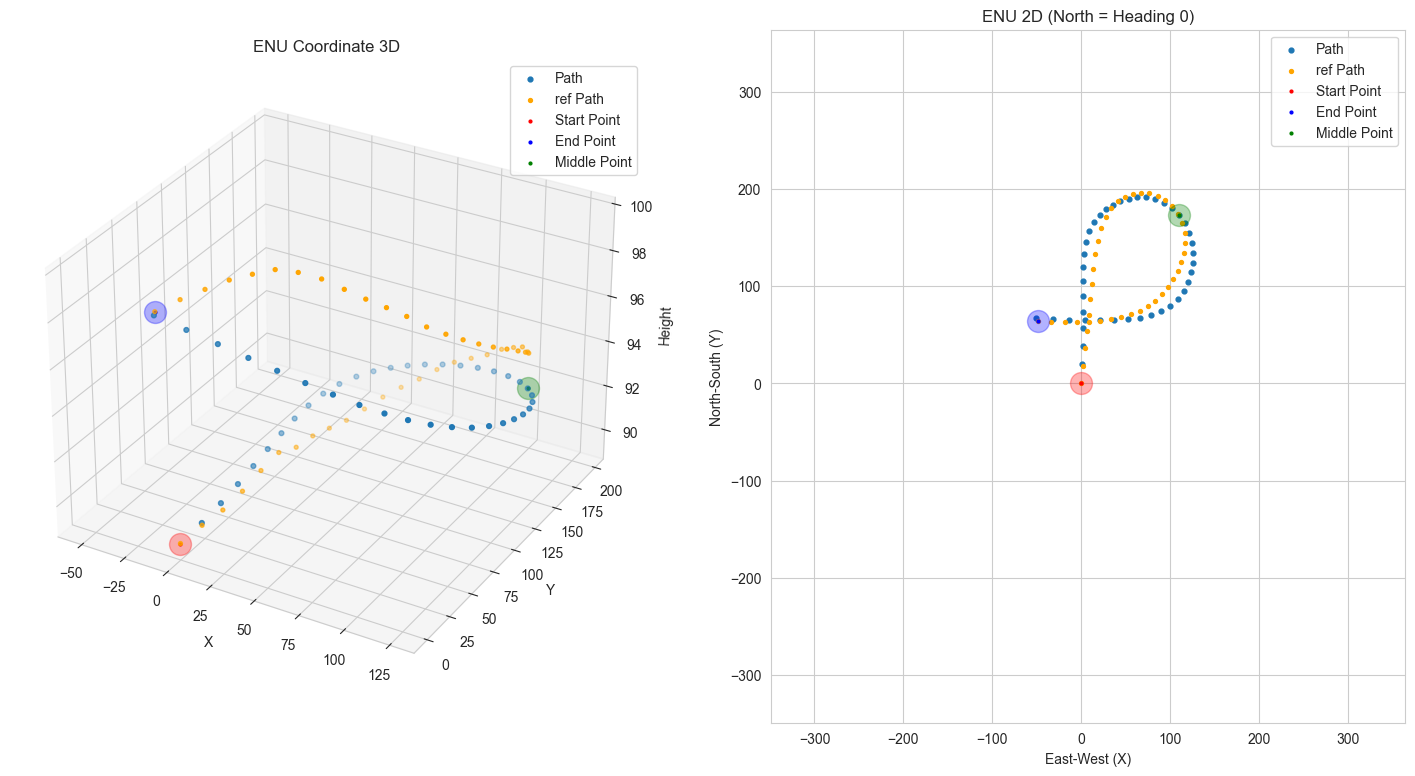

,lat,lon,height,Speed,Heading
0,36.533233,127.430463,89.579905,19.863973,0.065419
1,36.533403,127.430470,89.768274,18.947300,0.032992
2,36.533567,127.430470,89.952671,18.104951,0.001129
3,36.533721,127.430468,90.131635,17.096208,-0.013930
4,36.533866,127.430465,90.305692,16.161597,-0.015103
5,36.534004,127.430464,90.474971,15.239955,-0.005206
6,36.534132,127.430467,90.639037,14.265927,0.017267
7,36.534252,127.430480,90.797107,13.358010,0.091634
8,36.534364,127.430506,90.949331,12.596512,0.182220
9,36.534464,127.430549,91.093218,11.737025,0.335285


In [49]:
 import warnings

 warnings.filterwarnings('ignore')

ref_cal = ["lat", "lon", "height", "headMot", "numSV", "Speed"]

acc_file = pd.read_csv(fr"C:\Users\양준원\PycharmProjects\DPS_GPS_Outage\20240909.csv").drop(columns=["Unnamed: 0"])
acc_file = calibration(acc_file)

# 16000, 20500 | 16540:16576 : 교차로 2, 7940:7982 : 교차로 1
acc_file_norm = acc_file.loc[(acc_file["numSV"] > 10) & (acc_file["height"] > 0) & (acc_file["height"] < 1000) & (acc_file["Speed"] > 0)].copy()

# data_ = acc_file.loc[10000:20000].copy()  #26000:32200
# data_["idx"] = data_.index
# fig = px.scatter_mapbox(data_, lat = f'lat', lon= f'lon', color= f"idx", zoom=15, mapbox_style='open-street-map', color_continuous_scale='turbo').update_traces(marker={'size':5})
# fig.update_layout(
#      width = 1200,
#      height = 900,
#      margin = dict(l=0, r=0, t=0, b=0),
#  )
# fig.show()

result = detection(data_)
# print(np.sum(data["Speed"]), "Km GPS Outage part included")
#
# for result_ in result:
#     if len(result_) > 5:
#         data = data.loc[data.index.isin(result_.index) == False].copy()
# data.reset_index(inplace=True)
data_["idx"] = data_.index

print(np.sum(data_["Speed"]), "m GPS Outage part removed")

result = [acc_file.loc[7940:7982].copy()]


s, e, delta_s, time_delta_s = initialize(result[0], linear_slope=True)
ss, ee, delta_e, time_delta_e = initialize(result[0], reverse=True, linear_slope=True)

path_bi, path_e_s, delta_bi, delta_e_s = bi_direction(s, e, delta_s, delta_e, alpha = 3)


optimizer_ = optimizer(s, e, delta_bi, max_iter=200) # 300 이전에 보통 local minima
opt_result(s, e, optimizer_, result[0][ref_cal], show = False)
optimizer_.optimize()
opt_result(s, e, optimizer_, result[0][ref_cal], show = True)

# ext_sections = [
#     [26240, 26280], [26930, 26970], [27240, 27280], [27600, 27640], [28260, 28300], [28860, 28900], #[30500, 30540]
# ]
# ext_part = []
#
# for ext_section in ext_sections:
#     ext_part.append(data_.loc[ext_section[0]:ext_section[1]])
#
# print(np.sum(pd.concat(ext_part, axis = 0)["Speed"]), "m some Part removed")
#
# case_A = data_.copy()
# case_B = data_.loc[data_.index.isin(pd.concat(ext_part, axis = 0).index) == False].copy()
# print(np.sum(case_B["Speed"]), "m GPS Outage part removed")
#
# case_C = data_.copy()
#
# for ext_part_ in ext_part[:]:
#     s, e, delta_s, time_delta_s = initialize(ext_part_, linear_slope=True)
#     ss, ee, delta_e, time_delta_e = initialize(ext_part_, reverse=True, linear_slope=True)
#
#     path_bi, path_e_s, delta_bi, delta_e_s = bi_direction(s, e, delta_s, delta_e, alpha = 10)
#
#     # optimizer_ = optimizer(s, e, delta_bi)
#     # opt_result(s, e, optimizer_, data_[ref_cal])
#     # optimizer_.optimize()
#     # opt_result(s, e, optimizer_, data_[ref_cal])
#
#     optimizer_ = optimizer(s, e, delta_bi, max_iter=300) # 300 이전에 보통 local minima
#     opt_result(s, e, optimizer_, ext_part_[ref_cal], show = False)
#     optimizer_.optimize()
#     recovered = opt_result(s, e, optimizer_, ext_part_[ref_cal], show = False)
#
#     recovered.index = ext_part_.index[1:]
#     recovered["headMot"] = recovered["Heading"]
#     case_C.loc[case_C.index.isin(ext_part_.index), ["lat", "lon", "height", "Speed", "headMot"]] = pd.concat([ext_part_.iloc[:1], recovered], axis = 0)
#
# print(case_C.describe())

In [29]:
case_A[["lat", "lon", "height", "Speed", "headMot", "AccelX", "AccelY"]].to_csv(fr"C:\Users\양준원\Desktop\논문\data\case_A.csv")
case_B[["lat", "lon", "height", "Speed", "headMot", "AccelX", "AccelY"]].to_csv(fr"C:\Users\양준원\Desktop\논문\data\case_B.csv")
case_C[["lat", "lon", "height", "Speed", "headMot", "AccelX", "AccelY"]].to_csv(fr"C:\Users\양준원\Desktop\논문\data\case_C.csv")

Height diff as -8.449000000000012   estimated as -8.0298954418209
Speed diff as -6.289999999999999   estimated as -5.315475037965701
Heading diff as -1.8699361612758392   estimated as 4.386481147294521
Slope diff as -0.017897739057685727   estimated as -0.015453540543423405
X diff as 49.49879588202135   estimated as 48.89633552939002
Y diff as -41.07580409955361   estimated as -39.68249714645188
start heading : 3.153209565091068 X : 0.0 Y : 0.0 height : 502.045 slope : -0.0114906548955005 speed : 26.02
end heading : 1.283273403815229 X : 49.49879588202135 Y : -41.07580409955361 height : 493.596 slope : -0.029388393953186227 speed : 19.73
estimated end heading : 7.539690712385589 X : 48.89633552939002 Y : -39.68249714645188 height : 494.01510455817913 slope : -0.015453540543423405 speed : 20.7045249620343
--------------------
x diff as [3.01839887 5.23440957 6.4111941  6.99106452 6.86448428 5.78121995
 4.12233192 2.11404152 0.23820786 1.64373321 3.34805109 4.81079751
 5.91460305 6.69946

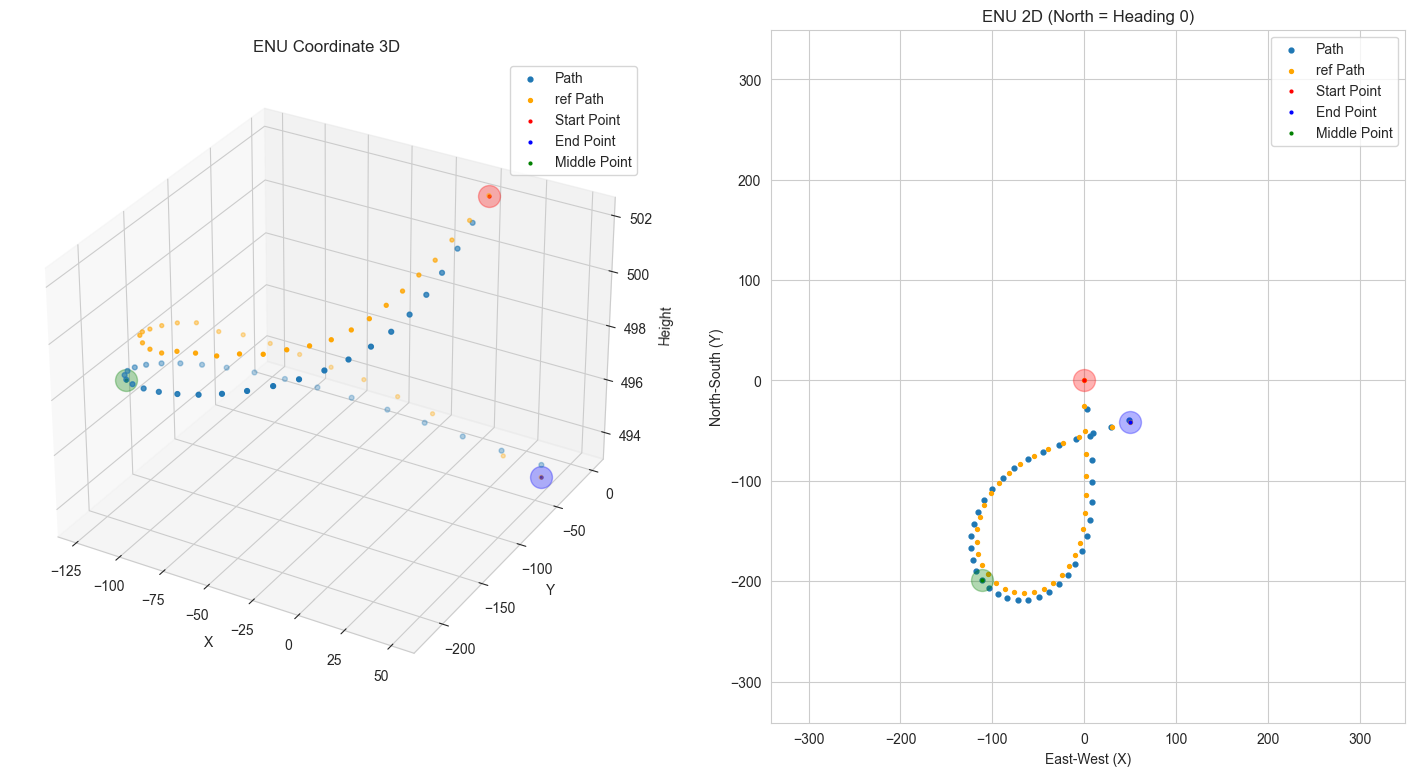

,lat,lon,height,Speed,Heading
0,35.842499,127.646409,501.787387,28.939222,3.032706
1,35.842261,127.646442,501.539407,26.565297,3.030058
2,35.842042,127.646464,501.301599,24.390138,3.059917
3,35.841844,127.646475,501.077164,22.009697,3.095938
4,35.841665,127.646471,500.866530,19.882249,3.158411
5,35.841505,127.646448,500.669997,17.864455,3.256596
6,35.841361,127.646407,500.482974,16.405117,3.371958
7,35.841230,127.646346,500.299591,15.506111,3.504502
8,35.841114,127.646268,500.118036,14.749643,3.636657
9,35.841013,127.646175,499.938511,14.020086,3.790904


In [48]:
#optimizer_.optimize()
opt_result(s, e, optimizer_, result[0][ref_cal], show = True)